<a href="https://colab.research.google.com/github/rahiakela/gans-in-action/blob/part-1-introduction-to-gans-and-generative-modeling/chapter_3_generating_handwritten_digits_using_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating handwritten digits using GANs

We will implement a GAN that learns to produce realistic-looking handwritten digits. We will use the Python neural network library Keras with a TensorFlow backend.

Over the course of the training iterations, the Generator learns to turn random noise input into images that look like members of the training data: the MNIST dataset of handwritten digits. 

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/gan-network.png?raw=1' width='800'/>

Simultaneously, the Discriminator learns to distinguish the fake images produced by the Generator from the genuine ones coming from the training dataset.



## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import  mnist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

We specify the input dimensions of our model and dataset. Each image in MNIST is 28 × 28 pixels with a single channel (because the images are grayscale). The variable z_dim sets the size of the noise vector, z.

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

##  Implementing the Generator

For simplicity, the Generator is a neural network with only a single hidden layer. It takes in z as input and produces a 28 × 28 × 1 image. In the hidden layer, we use the Leaky ReLU activation function. 

Unlike a regular ReLU function, which maps any negative input to 0, Leaky ReLU allows a small positive gradient. This prevents gradients from dying out during training, which tends to yield better training outcomes.

At the output layer, we employ the tanh activation function, which scales the output values to the range $[–1, 1]$. The reason for using tanh (as opposed to, say, sigmoid, which would output values in the more typical 0 to 1 range) is that tanh tends to produce crisper images.

In [0]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Dense(28 * 28 * 1, activation='tanh'))
  # Reshape the Generator output to image dimensions
  model.add(Reshape(img_shape))

  return model

## Implementing the Discriminator

The Discriminator takes in a 28 × 28 × 1 image and outputs a probability indicating whether the input is deemed real ratherthan fake. The Discriminator is represented by a two-layer neural network, with 128 hidden units and a Leaky ReLU activation function at the hidden layer.

For simplicity, our Discriminator network looks almost identical to the Generator. This does not have to be the case; indeed, in most GAN implementations, the Generator and Discriminator network architectures vary greatly in both size and complexity.

Notice that unlike for the Generator, in the following listing we apply the sigmoid activation function at the Discriminator’s output layer. This ensures that our output value will be between 0 and 1, so it can be interpreted as the probability the Generator assigns that the input is real.

In [0]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Dense(1, activation='sigmoid'))

  return model

## Building the model

Notice that in the combined model used to train the Generator, we keep the Discriminator parameters fixed by setting discriminator.trainable to False. Also note that the combined model, in which the Discriminator is set to untrainable, is used to train the Generator only. The Discriminator is trained as an independently compiled model. 

We use binary cross-entropy as the loss function we are seeking to minimize during training. Binary cross-entropy is a measure of the difference between computed probabilities and actual probabilities for predictions with only two possible classes. The greater the cross-entropy loss, the further away our predictions are from the true labels.

To optimize each network, we use the Adam optimization algorithm. This algorithm, whose name is derived from adaptive moment estimation, is an advanced gradient-descent-based optimizer. Adam has become the go-to optimizer for most GAN implementations thanks to its often superior performance

In [0]:
def build_gan(generator, discriminator):
  model = Sequential()

  # Combined Generator -> Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training GAN

We get a random mini-batch of MNIST images as real examples and generate a mini-batch of fake images from random noise vectors z. We then use those to train the Discriminator network while keeping the Generator’s parameters constant. 

Next we generate a mini-batch of fake images and use those to train the Generator network while keeping the Discriminator’s parameters fixed.
We repeat this for each iteration.

We use one-hot-encoded labels: 1 for real images and 0 for fake ones. To generate z, we sample from the standard normal distribution (a bell curve with 0 mean and a standard deviation of 1). 

The Discriminator is trained to assign fake labels to the fake images and real labels to real images. The Generator is trained such that the Discriminator assigns real labels to the fake examples it produces.

Notice that we are rescaling the real images in the training dataset from –1 to 1. As you saw in the preceding example, the Generator uses the tanh activation function at the output layer, so the fake images will be in the range (–1, 1). Accordingly, we have to rescale all the Discriminator’s inputs to the same range.

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:
      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print('%d [Discriminator loss: %f, accuracy: %.2f%%] [Generator loss: %f]' % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

This function gets called every sample_interval iterations and outputs a 4 × 4 grid of images synthesized by the Generator in the given iteration. After we run our model, we will use these images to inspect interim and final outputs.

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt +=1

## Running the model

We set the training hyperparameters—the number of iterations and the batch size—and train the model. There is no tried-and-true method to determine the right number of iterations or the right batch size; we determine them experimentally through trial and error as we observe the training progress.

That said, there are important practical constraints to these numbers: each mini-batch must be small enough to fit inside the processing memory (typical batch sizes people use are powers of 2: 32, 64, 128, 256, and 512). 

The number of iterations also has a practical constraint: the more iterations we have, the longer the training process takes. With complex deep learning models like GANs, this can get out of hand quickly, even with significant computing power.

To determine the right number of iterations, we monitor the training loss and set the iteration number around the point when the loss plateaus, indicating that we are getting little to no incremental improvement from further training.

Note that the **Discrepancy between trainable weights and collected trainable** warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

1000 [Discriminator loss: 0.111201, accuracy: 95.31%] [Generator loss: 4.533691]
2000 [Discriminator loss: 0.151205, accuracy: 94.14%] [Generator loss: 5.817727]
3000 [Discriminator loss: 0.191748, accuracy: 91.80%] [Generator loss: 3.982768]
4000 [Discriminator loss: 0.330448, accuracy: 87.11%] [Generator loss: 3.757636]
5000 [Discriminator loss: 0.319090, accuracy: 89.06%] [Generator loss: 3.937778]
6000 [Discriminator loss: 0.435982, accuracy: 81.25%] [Generator loss: 3.409435]
7000 [Discriminator loss: 0.237017, accuracy: 88.67%] [Generator loss: 3.709594]
8000 [Discriminator loss: 0.411399, accuracy: 85.16%] [Generator loss: 3.121718]
9000 [Discriminator loss: 0.505845, accuracy: 78.91%] [Generator loss: 3.016218]
10000 [Discriminator loss: 0.342545, accuracy: 86.33%] [Generator loss: 3.266891]
11000 [Discriminator loss: 0.324794, accuracy: 87.50%] [Generator loss: 2.991682]
12000 [Discriminator loss: 0.404158, accuracy: 84.77%] [Generator loss: 2.774924]
13000 [Discriminator loss

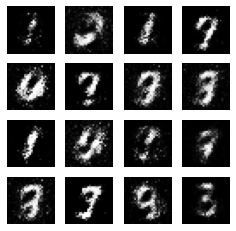

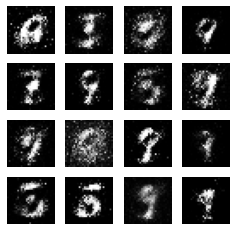

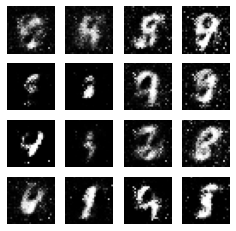

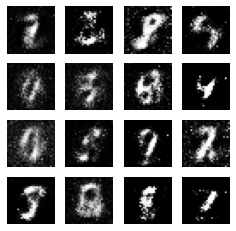

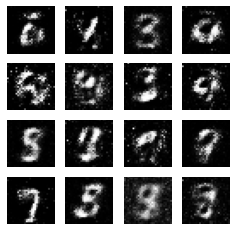

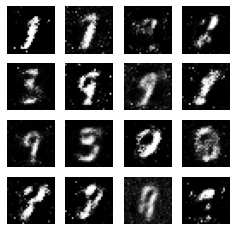

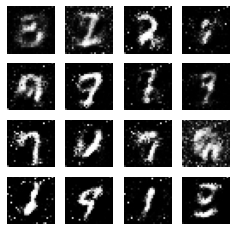

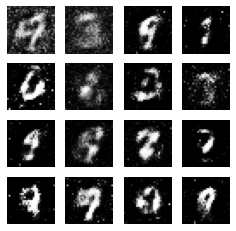

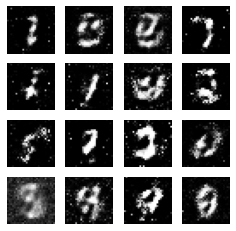

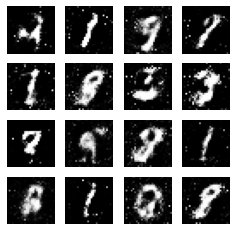

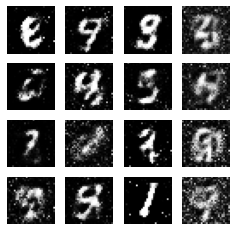

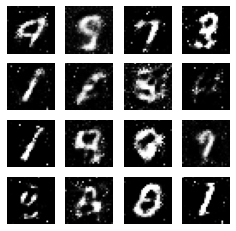

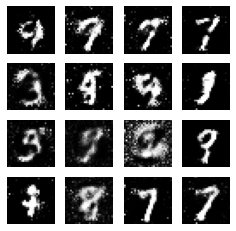

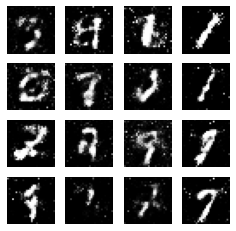

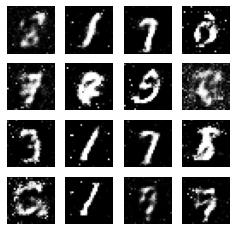

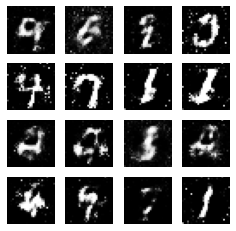

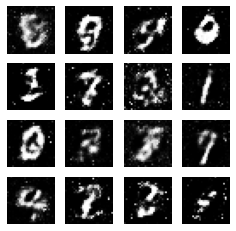

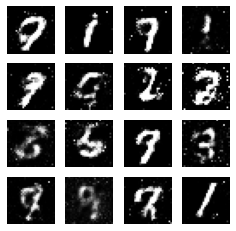

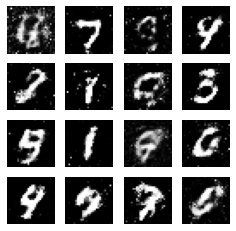

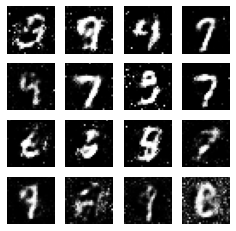

In [12]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

As you can see, the Generator starts out by producing little more than random noise. Over the course of the training iterations, it gets better and better at emulating the features of the training data. Each time the Discriminator rejects a generated image as false or accepts one as real, the Generator improves a little.

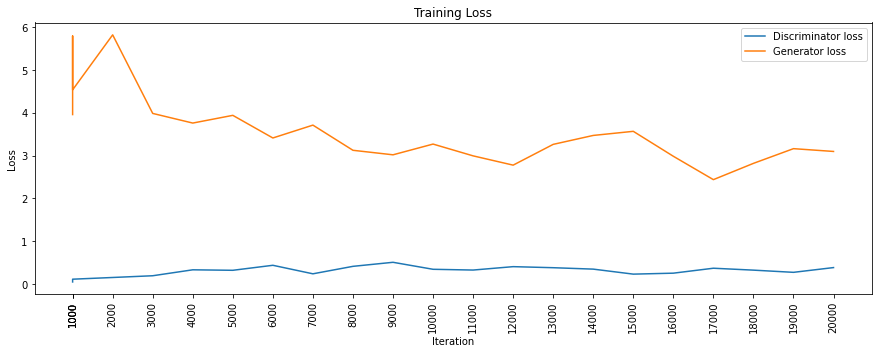

In [13]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

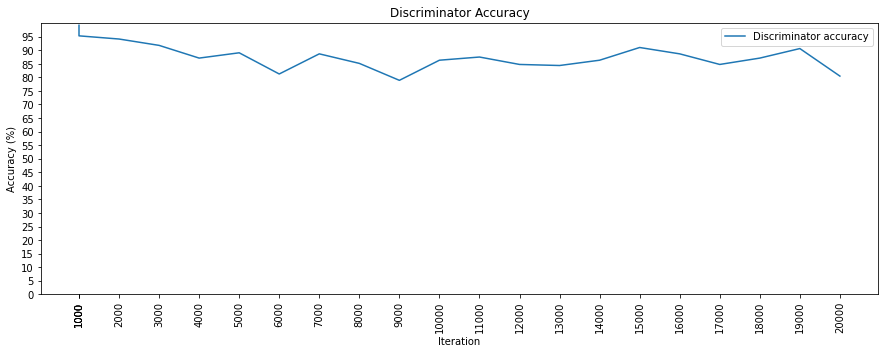

In [14]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

## Conclusion

Although the images our GAN generated are far from perfect, many of them are easily recognizable as real numerals—an impressive achievement, given that we used only a simple two-layer network architecture for both the Generator and the Discriminator.

